<a href="https://colab.research.google.com/github/SaifuliAnna/DataScience_HW12/blob/main/HW_12(CNN_part_3_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.vgg16 import VGG16

from keras import layers, models, Model

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import itertools
from keras import callbacks

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt# Reading Train Data
from keras.datasets import fashion_mnist

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print("Shape of Train : " + str(train_images.size))
print("Shape of Train : " + str(train_labels.size))
print("Shape of Train : " + str(test_images.size))
print("Shape of Train : " + str(test_labels.size))

4422102/4422102 [==============================] - 0s 0us/step
Shape of Train : 47040000
Shape of Train : 60000
Shape of Train : 7840000
Shape of Train : 10000


In [3]:
Y_train = train_labels
X_train = train_images
X_test = test_images
Y_test = test_labels

print("Shape of Train : " + str(Y_train.shape))
print("Shape of Train : " + str(X_train.shape))
print("Shape of Train : " + str(X_test.shape))
print("Shape of Train : " + str(Y_test.shape))

Shape of Train : (60000,)
Shape of Train : (60000, 28, 28)
Shape of Train : (10000, 28, 28)
Shape of Train : (10000,)


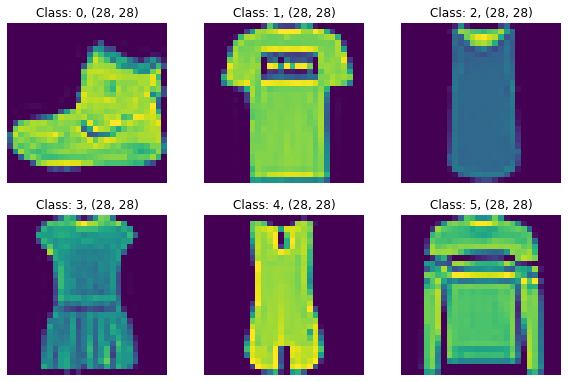

In [ ]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3,3,i+1)
    img = X_train[i]
    plt.imshow(img)
    plt.title(f"Class: {str(i)}, {X_train[i].shape}")
    plt.axis('off')
    
plt.show()

Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

print("x_train shape",x_train.shape)
print("x_test shape",x_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

x_train shape (42000, 28, 28)
x_test shape (18000, 28, 28)
y_train shape (42000,)
y_test shape (18000,)


In [5]:
# Нормализуем значения пикселей в диапазоне от 0 до 1
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0

X_test = X_test.astype("float32") / 255.0

In [6]:
x_train = np.stack((x_train,)*3, axis=-1)
x_val = np.stack((x_val,)*3, axis=-1)

X_test = np.stack((X_test,)*3, axis=-1)

print("Shape of Train : " + str(x_train.shape))
print("Shape of Valid : " + str(x_val.shape))

print("Shape of Test : " + str(X_test.shape))

Shape of Train : (42000, 28, 28, 3)
Shape of Valid : (18000, 28, 28, 3)
Shape of Test : (10000, 28, 28, 3)


In [7]:
# Resizing images
x_train = tf.image.resize(x_train, (32, 32))
x_val = tf.image.resize(x_val, (32, 32))

X_test = tf.image.resize(X_test, (32, 32))

print("Shape of Train : " + str(x_train.shape))
print("Shape of Valid : " + str(x_val.shape))

print("Shape of Test : " + str(X_test.shape))

Shape of Train : (42000, 32, 32, 3)
Shape of Valid : (18000, 32, 32, 3)
Shape of Test : (10000, 32, 32, 3)


In [8]:
# Transforming labels to correct format
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

Y_test = to_categorical(Y_test, num_classes=10)

print("Shape of Train : " + str(y_train.shape))
print("Shape of Valid: " + str(y_val.shape))

print("Shape of Test : " + str(Y_test.shape))

Shape of Train : (42000, 10)
Shape of Valid: (18000, 10)
Shape of Test : (10000, 10)


Defining the parameters for instanitaing VGG16 model.

In [9]:
# Loading VGG16 model
# Загружаем предобученную сеть VGG16 без последних слоев
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))


conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:    
    if layer.name == "block5_conv1":        
        set_trainable = True    
    if set_trainable:        
        layer.trainable = True    
    else:        
        layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Create Model

In [10]:
model = models.Sequential([   
    conv_base,   
    layers.Flatten(),  
    layers.Dense(512, activation="relu"),   
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

Optimizer

Adam optimizer we can say adam optimizer updates leraning rate dynamically.

In [11]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);

Compile Model

Since we have 10 classes we’ll use categorical crossentropy.

In [12]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

Epoch and Batch Size

Epoch is the number of times the algorithm sees the entire data set. If one epoch is too big to run to the computer at once we divide it smaller parts and number of this parts is called batch.

In [ ]:
# epochs = 100
# batchSize = 300
# steps_per_epoch=x_train.shape[0] // batchSize

Data Augmentation

By using “data augmentation” we can create new data with different orientations. It prevents overfitting.

Data Augmentation

By using “data augmentation” we can create new data with different orientations. It prevents overfitting.

Reduced learning and Early stopping for callback Implementation

In [13]:
np.random.seed(300)

Fit The Model

In [14]:
# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.1,  # randomly rotate images in the range
        zoom_range =0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip imagesdatagen.fit(x_train)

datagen.fit(x_train)

In [15]:
fash_vgg = model.fit(datagen.flow(x_train, y_train, batch_size=256), epochs=20, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
165/165 [==============================] - 44s 199ms/step - loss: 0.6467 - accuracy: 0.7666 - val_loss: 0.4246 - val_accuracy: 0.8479
Epoch 2/20
165/165 [==============================] - 31s 188ms/step - loss: 0.4202 - accuracy: 0.8456 - val_loss: 0.3709 - val_accuracy: 0.8618
Epoch 3/20
165/165 [==============================] - 31s 186ms/step - loss: 0.3711 - accuracy: 0.8638 - val_loss: 0.3346 - val_accuracy: 0.8744
Epoch 4/20
165/165 [==============================] - 31s 187ms/step - loss: 0.3451 - accuracy: 0.8731 - val_loss: 0.3154 - val_accuracy: 0.8809
Epoch 5/20
165/165 [==============================] - 31s 187ms/step - loss: 0.3293 - accuracy: 0.8788 - val_loss: 0.2910 - val_accuracy: 0.8916
Epoch 6/20
165/165 [==============================] - 31s 189ms/step - loss: 0.3096 - accuracy: 0.8868 - val_loss: 0.2922 - val_accuracy: 0.8892
Epoch 7/20
165/165 [==============================] - 30s 184ms/step - loss: 0.3004 - accuracy: 0.8897 - val_loss: 0.2818 - val_ac

In [ ]:
model.save("my_model_fash_vgg_3")

Evaluate The Model

In [16]:
test_loss, test_acc = model.evaluate(x_val, y_val)

print(f'\nTest loss:{test_loss},    Test accuracy:{test_acc}')

563/563 [==============================] - 5s 9ms/step - loss: 0.2674 - accuracy: 0.9039

Test loss:0.2673591375350952,    Test accuracy:0.9039444327354431


In [17]:
print(f"Accuracy after fitting: {fash_vgg.history['accuracy'][-1]*100}%")

# For better accuracy i can increase number of epochs or i can change 
# parameters on layers or i can add additional layer to the model.

Accuracy after fitting: 91.98095202445984%


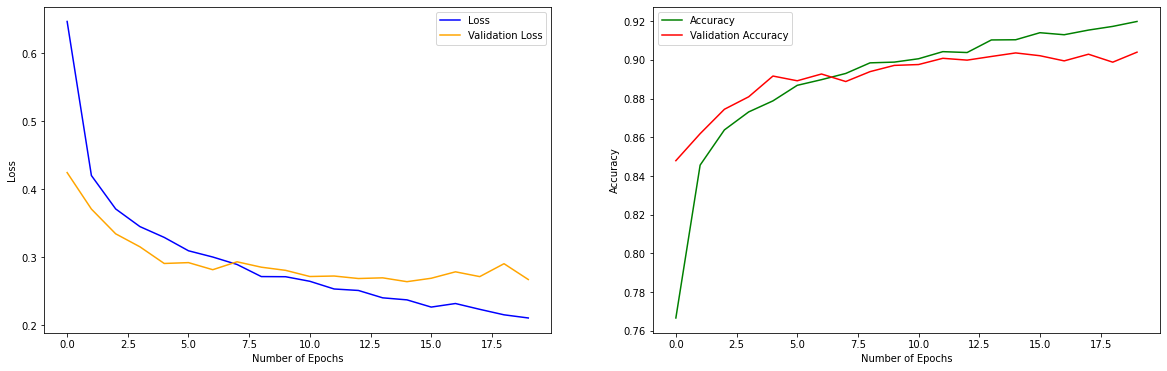

In [18]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(fash_vgg.history['loss'], color="blue", label = "Loss")
plt.plot(fash_vgg.history['val_loss'], color="orange", label = "Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(fash_vgg.history['accuracy'], color="green", label = "Accuracy")
plt.plot(fash_vgg.history['val_accuracy'], color="red", label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

out score by giving test data we imported before

In [19]:
# Y_test = to_categorical(Y_test, num_classes=10) # One-Hot Encoding
score = model.evaluate(X_test, Y_test)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]*100}%")

313/313 [==============================] - 3s 10ms/step - loss: 0.2974 - accuracy: 0.8968
Test Loss: 0.2973608672618866
Test Accuracy: 89.67999815940857%


313/313 [==============================] - 3s 9ms/step


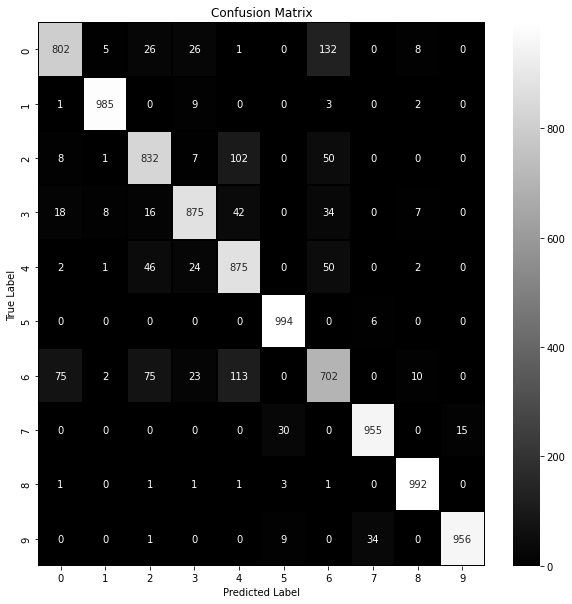

In [20]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)
confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
for i in range(len(confusionMatrix)):
    print(f"Class: {str(i)}")
    print(f"Number of Wrong Prediction: {str(sum(confusionMatrix[i])-confusionMatrix[i][i])} out of 1000")
    print(f"Percentage of True Prediction: {confusionMatrix[i][i] / 10}% ")
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

Class: 0
Number of Wrong Prediction: 166 out of 1000
Percentage of True Prediction: 83.4% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 1
Number of Wrong Prediction: 18 out of 1000
Percentage of True Prediction: 98.2% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 2
Number of Wrong Prediction: 63 out of 1000
Percentage of True Prediction: 93.7% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 3
Number of Wrong Prediction: 108 out of 1000
Percentage of True Prediction: 89.2% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 4
Number of Wrong Prediction: 212 out of 1000
Percentage of True Prediction: 78.8% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 5
Number of Wrong Prediction: 13 out of 1000
Percentage of True Prediction: 98.7% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 6
Number of Wrong Prediction: 378 out of 1000
Percentage of True Prediction: 62.2% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 7
Number of Wrong Prediction: 23 out of 1000
Percentage of True Prediction: 97.7% 
<<<<<<<<<<